## Titanic Survival Prediction Model

### Introduction

The RMS Titanic, a luxury steamship, sank in the early hours of April 15, 1912, off the coast of Newfoundland in the North Atlantic after sideswiping an iceberg during its maiden voyage. Of the 2,240 passengers and crew on board, more than 1,500 lost their lives in the disaster.

In this notebook I will be building a predictive model to identify the survival of the passengers.


### Load the data

##### Data Dictionary

Variable Definition Key

* survival - Survival: 0 = No, 1 = Yes

* pclass - Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd

* sex - Male or Female

* Age - Age (years)

* sibsp - Number of siblings / spouses aboard the Titanic

* parch - Number of parents / children aboard the Titanic

* ticket - Ticket number

* fare - Passenger fare

* cabin - Cabin number

* embarked - Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [108]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings('ignore')
%matplotlib inline

In [109]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.shape, test_df.shape

((891, 12), (418, 11))

In [110]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [111]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Finding missing values

In [112]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round((data.isnull().sum()/data.shape[0]*100).sort_values(ascending = False),2)
    
    ms = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms = ms[ms["Percent"] > 0]
    f,ax = plt.subplots()
    plt.xticks(rotation='0')
    fig = sns.barplot(ms.index, ms["Percent"],color="blue",alpha=0.8)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Percent of missing values', fontsize=12)
    plt.title('Missing data by features (%)', fontsize=18)

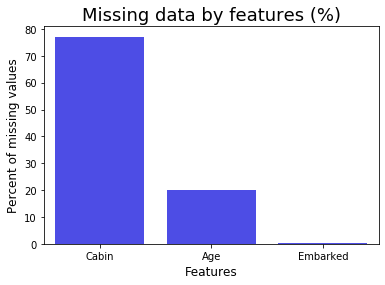

In [113]:
missingdata(train_df)

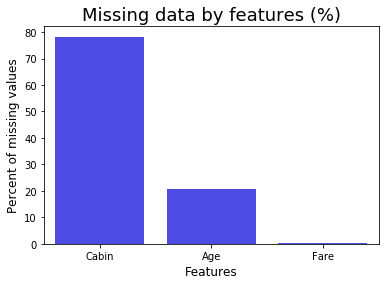

In [114]:
missingdata(test_df)

### Filling missing values

#### Cabin

Cabin Feature has more than 75% of missing data in both Test and train data. So, its best to drop the Cabin column.

In [115]:
drop_column = ['Cabin']

train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column,axis=1,inplace=True)

#### Age

Both the test and train Age features contains more the 15% of missing values. So, let's fill it with the median.

In [116]:
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

#### Embarked

In [117]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

#### Fare

In [118]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

In [119]:
print('Checking the null values in train data')
print(train_df.isnull().sum())

print('_ _ _ '*15)
print()

print('Checking the null values in test data')
print(test_df.isnull().sum())

Checking the null values in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Checking the null values in test data
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


### Feature Engineering

We can create additional features from our existing set of features.

In [120]:
df = [train_df,test_df]

#### FamilySize as a combination of SibSp and Parch

In [121]:
for dataset in df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#### Extract Title from name

In [122]:
def get_title(name):
    
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""

for dataset in df:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Mlle', 'Ms', 'Mme'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col','Don','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Mr')
    dataset['Title'] = dataset['Title'].replace('Dr', 'Rare')

#### Age bins

In [123]:
for dataset in df:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

#### Fare bins

In [124]:
for dataset in df:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

#### Dropping all unnecessary columns

In [125]:
for dataset in df:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [126]:
drop_column = ['PassengerId']
train_df.drop(drop_column, axis=1, inplace = True)

### Data Pre-processing

In [127]:
train_df = pd.get_dummies(train_df, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [128]:
test_df = pd.get_dummies(test_df, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

### Finding the correlation between the features

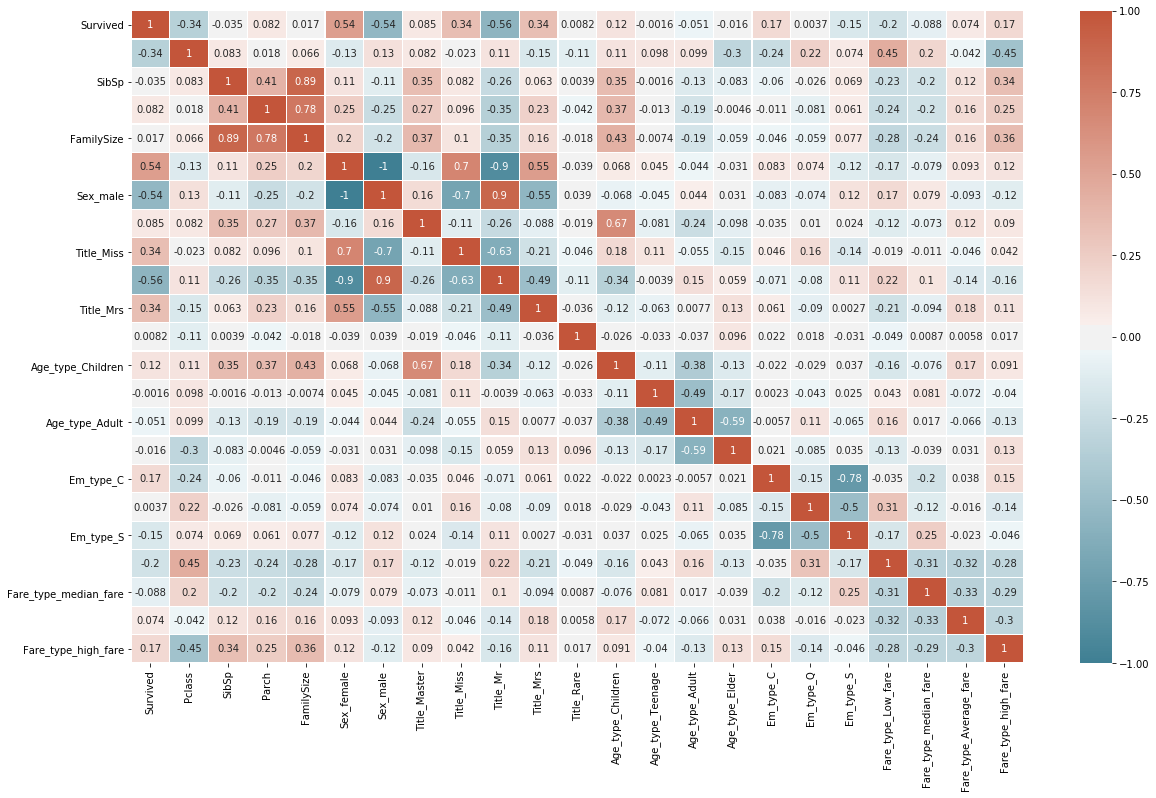

In [129]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(train_df.corr(), annot=True, cmap=cmap, linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### Modeling

Building Machine Learning models using Supervised Learning.

In [130]:
all_features = train_df.drop("Survived",axis=1)
Targeted_feature = train_df["Survived"]

X_train,X_test,y_train,y_test = train_test_split(all_features, Targeted_feature, stratify=Targeted_feature, test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

#### Logistic Regression

The accuracy of the Logistic Regression is 83.58
The cross validated score for Logistic REgression is: 82.15


Text(0.5, 1.05, 'Confusion_matrix')

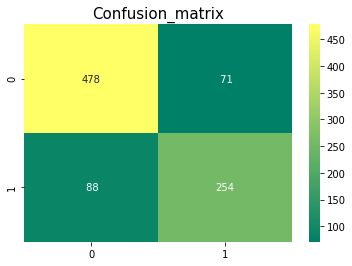

In [131]:
model = LogisticRegression()
model.fit(X_train,y_train)

prediction_lr = model.predict(X_test)

print('The accuracy of the Logistic Regression is',round(accuracy_score(prediction_lr,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_lr = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Logistic REgression is:',round(result_lr.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Random Forest

The accuracy of the Random Forest Classifier is 82.09
The cross validated score for Random Forest Classifier is: 83.95


Text(0.5, 1.05, 'Confusion_matrix')

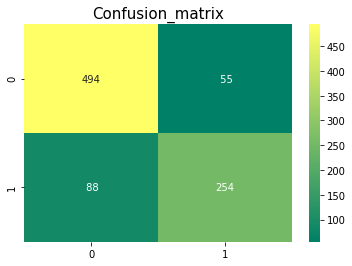

In [132]:
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)

model.fit(X_train,y_train)

prediction_rm = model.predict(X_test)

print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_rm = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### SVM

The accuracy of the Support Vector Machines Classifier is 82.09
The cross validated score for Support Vector Machines Classifier is: 83.05


Text(0.5, 1.05, 'Confusion_matrix')

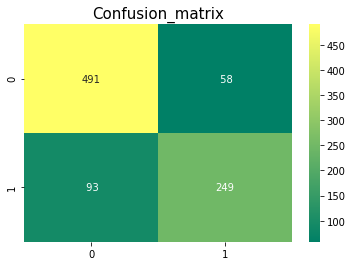

In [133]:
model = SVC()
model.fit(X_train,y_train)

prediction_svm = model.predict(X_test)

print('The accuracy of the Support Vector Machines Classifier is',round(accuracy_score(prediction_svm,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_svm = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Support Vector Machines Classifier is:',round(result_svm.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### KNN

The accuracy of the K Nearst Neighbors Classifier is 80.6
The cross validated score for K Nearest Neighbors Classifier is: 81.27


Text(0.5, 1.05, 'Confusion_matrix')

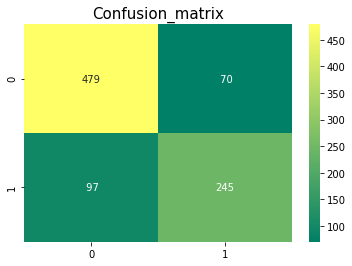

In [134]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train,y_train)

prediction_knn = model.predict(X_test)

print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_knn = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Naive Bayes

The accuracy of the Gaussian Naive Bayes Classifier is 80.22
The cross validated score for Gaussian Naive Bayes classifier is: 79.69


Text(0.5, 1.05, 'Confusion_matrix')

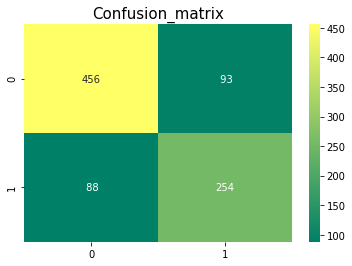

In [135]:
model= GaussianNB()
model.fit(X_train,y_train)

prediction_gnb = model.predict(X_test)

print('The accuracy of the Gaussian Naive Bayes Classifier is',round(accuracy_score(prediction_gnb,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_gnb = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Gaussian Naive Bayes classifier is:',round(result_gnb.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Decision Tree

The accuracy of the DecisionTree Classifier is 74.25
The cross validated score for Decision Tree classifier is: 82.72


Text(0.5, 1.05, 'Confusion_matrix')

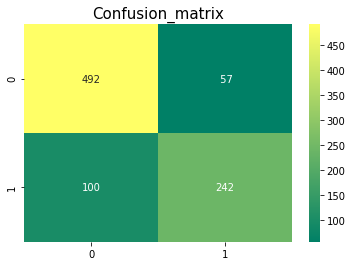

In [136]:
model = DecisionTreeClassifier(criterion='gini',
                             min_samples_split=10, min_samples_leaf=1,
                             max_features='auto')
model.fit(X_train,y_train)

prediction_tree = model.predict(X_test)

print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(prediction_tree,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_tree = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Decision Tree classifier is:',round(result_tree.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### AdaBoost

The accuracy of the AdaBoostClassifier is 82.46
The cross validated score for AdaBoostClassifier is: 81.48


Text(0.5, 1.05, 'Confusion_matrix')

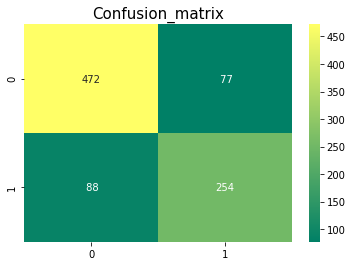

In [137]:
model = AdaBoostClassifier()
model.fit(X_train,y_train)

prediction_adb = model.predict(X_test)

print('The accuracy of the AdaBoostClassifier is',round(accuracy_score(prediction_adb,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_adb = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_adb.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Linear Discriminant Analysis

The accuracy of the LinearDiscriminantAnalysis is 83.21
The cross validated score for AdaBoostClassifier is: 82.38


Text(0.5, 1.05, 'Confusion_matrix')

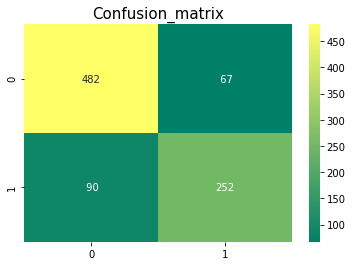

In [138]:
model = LinearDiscriminantAnalysis()
model.fit(X_train,y_train)

prediction_lda = model.predict(X_test)

print('The accuracy of the LinearDiscriminantAnalysis is',round(accuracy_score(prediction_lda,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_lda = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_lda.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

#### Gradient Boosting Classifier

The accuracy of the Gradient Boosting Classifier is 81.34
The cross validated score for AdaBoostClassifier is: 82.16


Text(0.5, 1.05, 'Confusion_matrix')

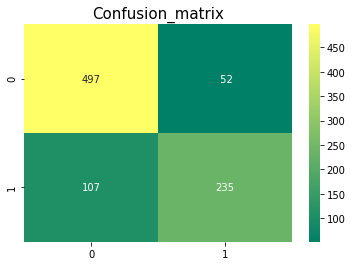

In [139]:
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

prediction_gbc = model.predict(X_test)

print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(prediction_gbc,y_test)*100,2))

kfold = KFold(n_splits=10, random_state=22)
result_gbc = cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_gbc.mean()*100,2))

y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

### Model Evaluation

In [140]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Decent', 'Linear Discriminant Analysis', 
              'Decision Tree'],
    'Score': [result_svm.mean(), result_knn.mean(), result_lr.mean(), 
              result_rm.mean(), result_gnb.mean(), result_adb.mean(), 
              result_gbc.mean(), result_lda.mean(), result_tree.mean()]})
models.sort_values(by='Score',ascending=False)

,Model,Score
3,Random Forest,0.839538
0,Support Vector Machines,0.830524
8,Decision Tree,0.827216
7,Linear Discriminant Analysis,0.823833
6,Gradient Decent,0.821598
2,Logistic Regression,0.821548
5,AdaBoostClassifier,0.814819
1,KNN,0.812659
4,Naive Bayes,0.796866


By looking at all the matrices, we can say that Random Forest Classifier & SVM classifier have a higher chance in correctly predicting survival of passengers.